In [1]:
library(ggplot2)
library(cowplot)
library(reshape2)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
asv_tab_full <- read.table("data/asv_table.tab", comment.char="", header=1, skip=1, sep="\t", row.names=1)
taxonomy <- read.table("data/taxonomy.tsv", sep="\t", header=1, row.names=1)
md <- read.table("data/METADATA.txt", sep="\t", header=1, row.names=1, comment.char="")
asv_tab <- scale(asv_tab_full, center=FALSE, scale=colSums(asv_tab_full))
asv_tab <- merge(taxonomy, asv_tab, by=0)
asv_tab <- melt(asv_tab[,! colnames(asv_tab) %in% c("Confidence")]) # Exclude the confidence column
asv_tab$variable <- gsub("^X","", asv_tab$variable)

Using Row.names, Taxon as id variables


In [3]:
cut_taxonomy_string <- function(x, n) {
    sp <- unlist(strsplit(x,";"))
    if (length(sp) >= n) {
        return(sp[n])
        }
    else {
        return(sp[length(sp)])
    }
}

get_melted_taxon_table <- function(n) {
    rel_abund_tab <- aggregate(asv_tab$value, by=list(asv_tab$variable, asv_tab$Taxon), FUN=sum)
    colnames(rel_abund_tab) <- c("SampleID", "Taxon", "RelAbund")
    rel_abund_tab$Classification <- unlist(lapply(as.character(rel_abund_tab$Taxon), function(x) cut_taxonomy_string(x, n)))
    rel_abund_tab
}

## Taxonomy Bar Plot

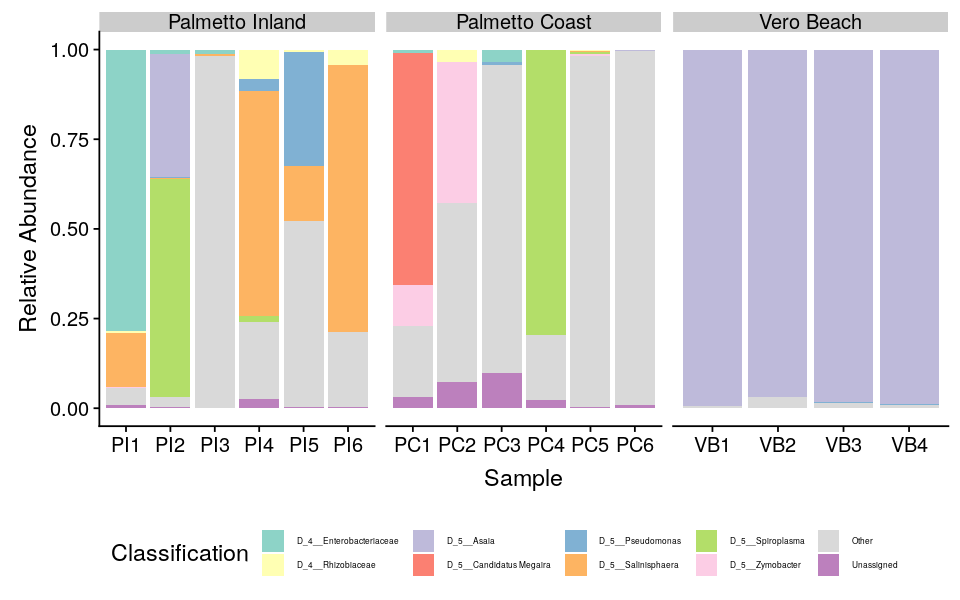

In [4]:
options(repr.plot.height=5, repr.plot.width=8)
#pdf("Figure3.pdf", height=5, width=8)
genus_tab <- get_melted_taxon_table(6)
mean_tab <- aggregate(genus_tab$RelAbund, by=list(genus_tab$Classification), FUN=mean)
abundant <- mean_tab[mean_tab$x > 0.01,"Group.1"]
genus_tab[! genus_tab$Classification %in% abundant, "Classification"] <- "Other"
genus_tab$Location <- md[genus_tab$SampleID,"location"]
genus_tab$Location <- as.factor(genus_tab$Location)
levels(genus_tab$Location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach")
genus_tab$SampleID <- as.factor(genus_tab$SampleID)
levels(genus_tab$SampleID) <- c("VB1","VB2","VB3","VB4","PC1","PC2","PC3","PC4","PC5","PI1","PI2","PI3","PI4","PI5","PI6","PC6")
ggplot(genus_tab, aes(x=SampleID, y=RelAbund, fill=Classification)) + 
    geom_bar(stat='identity') + theme(legend.position='bottom', legend.text=element_text(size=5)) +
    scale_fill_brewer(palette='Set3') + facet_grid(.~Location, scales = "free") + xlab("Sample") + ylab("Relative Abundance")
#dev.off()

In [5]:
print_taxon_table <- function(level) {
    taxon_tab <- get_melted_taxon_table(level)
    # Aggregate and normalize by location
    taxon_tab$Location <- md[taxon_tab$SampleID,'location']
    taxon_tab$Location <- as.factor(taxon_tab$Location)
    levels(taxon_tab$Location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach")
    taxon_tab <- aggregate(taxon_tab$RelAbund, by=list(taxon_tab$Location, taxon_tab$Classification), FUN=sum)
    colnames(taxon_tab) <- c("Location", "Classification", "RelAbund")
    taxon_tab[taxon_tab$Location == 'Vero Beach','RelAbund'] <- taxon_tab[taxon_tab$Location == 'Vero Beach','RelAbund']/4*100
    taxon_tab[taxon_tab$Location == 'Palmetto Inland','RelAbund'] <- taxon_tab[taxon_tab$Location == 'Palmetto Inland','RelAbund']/6*100
    taxon_tab[taxon_tab$Location == 'Palmetto Coast','RelAbund'] <- taxon_tab[taxon_tab$Location == 'Palmetto Coast','RelAbund']/6*100
    # Round for pretty print
    taxon_tab$RelAbund <- round(taxon_tab$RelAbund, 2)
    # Re-cast as wide for viewing
    taxon_tab <- dcast(data = taxon_tab, formula = Classification~Location,fun.aggregate = sum,value.var = "RelAbund")
    # Order by largest row sums
    taxon_tab <- taxon_tab[order(rowSums(taxon_tab[,2:4]), decreasing=TRUE),]                                    
    taxon_tab
}

In [6]:
print_taxon_table(1)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
2,D_0__Bacteria,99.27,95.73,99.99
4,Unassigned,0.70,3.91,0.01
3,D_0__Eukaryota,0.03,0.37,0.00
1,D_0__Archaea,0.00,0.00,0.00


In [7]:
print_taxon_table(2)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
23,D_1__Proteobacteria,65.32,35.27,99.72
26,D_1__Spirochaetes,15.88,30.60,0.00
27,D_1__Tenericutes,10.39,13.41,0.00
5,D_1__Actinobacteria,2.92,5.66,0.01
7,D_1__Bacteroidetes,2.73,3.55,0.00
15,D_1__Firmicutes,0.66,4.42,0.04
29,Unassigned,0.70,3.91,0.01
11,D_1__Cyanobacteria,0.06,0.67,0.17
2,D_0__Bacteria,0.14,0.75,0.00
4,D_1__Acidobacteria,0.19,0.63,0.00


In [8]:
print_taxon_table(3)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
11,D_2__Alphaproteobacteria,13.45,19.05,98.64
25,D_2__Gammaproteobacteria,51.73,16.18,1.06
43,D_2__Spirochaetia,15.88,30.60,0.00
33,D_2__Mollicutes,10.39,13.41,0.00
10,D_2__Actinobacteria,2.63,4.32,0.01
15,D_2__Bacteroidia,2.73,3.55,0.00
53,Unassigned,0.70,3.91,0.01
14,D_2__Bacilli,0.36,1.70,0.02
20,D_2__Clostridia,0.07,1.85,0.02
37,D_2__Oxyphotobacteria,0.06,0.67,0.17


In [9]:
print_taxon_table(4)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
20,D_3__Acetobacterales,5.77,0.81,98.36
105,D_3__Spirochaetales,15.88,30.60,0.00
98,D_3__Salinisphaerales,28.08,0.01,0.31
54,D_3__Entomoplasmatales,10.39,13.41,0.00
53,D_3__Enterobacteriales,14.33,2.00,0.13
94,D_3__Rickettsiales,0.00,11.14,0.00
80,D_3__Oceanospirillales,0.65,8.77,0.00
88,D_3__Pseudomonadales,6.21,0.97,0.13
104,D_3__Sphingomonadales,3.34,3.13,0.18
92,D_3__Rhizobiales,3.38,2.37,0.09


In [10]:
print_taxon_table(5)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
41,D_4__Acetobacteraceae,5.77,0.81,98.35
161,D_4__Spirochaetaceae,15.88,30.60,0.00
152,D_4__Salinisphaeraceae,28.07,0.01,0.00
162,D_4__Spiroplasmataceae,10.39,13.41,0.00
77,D_4__Enterobacteriaceae,14.33,2.00,0.13
147,D_4__Rickettsiaceae,0.00,10.77,0.00
92,D_4__Halomonadaceae,0.65,8.77,0.00
160,D_4__Sphingomonadaceae,3.34,3.13,0.18
138,D_4__Pseudomonadaceae,5.85,0.19,0.12
189,Unassigned,0.70,3.91,0.01


In [11]:
print_taxon_table(6)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
101,D_5__Asaia,5.74,0.07,98.28
297,D_5__uncultured,16.42,32.51,0.03
261,D_5__Salinisphaera,28.07,0.01,0.00
276,D_5__Spiroplasma,10.39,13.41,0.00
49,D_4__Enterobacteriaceae,13.51,0.75,0.00
124,D_5__Candidatus Megaira,0.00,10.77,0.00
318,D_5__Zymobacter,0.03,8.54,0.00
237,D_5__Pseudomonas,5.85,0.19,0.12
320,Unassigned,0.70,3.91,0.01
65,D_4__Rhizobiaceae,2.31,0.62,0.05


In [12]:
print_taxon_table(7)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
95,D_5__Asaia,5.74,0.07,98.28
295,D_6__Spironema culicis,15.88,30.60,0.00
289,D_6__Salinisphaera hydrothermalis,28.07,0.01,0.00
228,D_5__Spiroplasma,10.39,13.41,0.00
49,D_4__Enterobacteriaceae,13.51,0.75,0.00
109,D_5__Candidatus Megaira,0.00,10.76,0.00
312,D_6__uncultured gamma proteobacterium,0.07,8.54,0.00
303,D_6__uncultured bacterium,0.34,6.52,0.07
199,D_5__Pseudomonas,5.85,0.11,0.12
330,Unassigned,0.70,3.91,0.01


In [13]:
#Peeking at the ASV table to see the dominating taxa
sorted_asvs <- asv_tab_full[order(rowSums(asv_tab_full), decreasing = TRUE),]
sorted_asvs$Taxonomy <- taxonomy[rownames(sorted_asvs),"Taxon"]
sorted_asvs[1:25,]
#To check for core, spoiler, with ASV resolution, nothing is core
#as.vector(apply(sorted_asvs[,1:ncol(sorted_asvs)-1],1, min))
#Search for specific taxa
#sorted_asvs[grep("Coetzeea", sorted_asvs$Taxonomy),]

,X54,X55,X56,X57,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X95,X96,Taxonomy
c8b9b7d30e9c691c55f6aad86fc2eb8d,7,0,0,0,19,0,0,0,66599,47,0,73827,26,0,35,160176,D_0__Bacteria;D_1__Spirochaetes;D_2__Spirochaetia;D_3__Spirochaetales;D_4__Spirochaetaceae;D_5__uncultured;D_6__Spironema culicis
8066a946c2bce93a8f4d4dae660448fa,40233,50978,50537,75803,38,0,0,0,0,0,0,0,8,0,0,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
64e629a02a50cf62088c6a47878fadb2,0,0,0,0,4,8,0,0,17,12683,286,271,40638,19081,133723,22,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Salinisphaerales;D_4__Salinisphaeraceae;D_5__Salinisphaera;D_6__Salinisphaera hydrothermalis
fef790186b76b2c4a3f6a44d0e19e0d1,27406,26717,29909,16643,0,0,0,0,0,0,33432,0,0,35,0,276,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
abee1e9056d2effd74db08e7bd14ec73,0,0,0,0,0,0,0,53691,548,0,1765,0,0,0,0,0,D_0__Bacteria;D_1__Tenericutes;D_2__Mollicutes;D_3__Entomoplasmatales;D_4__Spiroplasmataceae;D_5__Spiroplasma
3e5fa90804013842bbc91428155e8224,0,0,0,0,0,0,0,0,0,46286,0,0,0,0,0,19,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Enterobacteriales;D_4__Enterobacteriaceae
7749ac7c98a2d244d3c4f774c23f5618,0,0,0,0,0,0,0,0,0,0,36202,0,0,0,0,0,D_0__Bacteria;D_1__Tenericutes;D_2__Mollicutes;D_3__Entomoplasmatales;D_4__Spiroplasmataceae;D_5__Spiroplasma
0f1b2ed368ed60dc58ef54f925a9ebbf,0,0,0,0,0,0,0,19,0,0,0,0,0,35195,0,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Pseudomonadales;D_4__Pseudomonadaceae;D_5__Pseudomonas
e8797c11ecb2b8f029487937c45b2760,0,0,0,0,0,33008,11,0,0,0,0,0,0,0,0,5,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Oceanospirillales;D_4__Halomonadaceae;D_5__Zymobacter;D_6__uncultured gamma proteobacterium
fb4349ddb6b851c141f902ba3e79c7b2,0,0,0,0,0,0,0,0,0,0,21020,0,1120,0,0,0,D_0__Bacteria;D_1__Tenericutes;D_2__Mollicutes;D_3__Entomoplasmatales;D_4__Spiroplasmataceae;D_5__Spiroplasma


In [14]:
faprotab <- read.table("data//faprotax_report.txt", blank.lines.skip = TRUE, sep="\t")
asv_names <- c()
for (x in strsplit(as.character(faprotab$V1), " ")) {
    asv_names <- c(asv_names, x[5])
}
#Asaia
colSums(asv_tab_full[rownames(taxonomy)[grep("Asaia", taxonomy$Taxon)],])/colSums(asv_tab_full)
asv_names <- unique(asv_names)
sum(asv_tab_full[asv_names,])/sum(asv_tab_full)
length(asv_names)/dim(asv_tab_full[1])

X54          X55          X56          X57          X82          X83 
0.9930679536 0.9678122548 0.9829582936 0.9875235003 0.0012186127 0.0013234417 
         X84          X85          X86          X87          X88          X89 
0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.3441701497 0.0000000000 
         X90          X91          X95          X96 
0.0001132567 0.0002747706 0.0000000000 0.0013978010

[1] 0.3058289

[1]   0.2968961 440.0000000

In [15]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 17.04

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.7.0
LAPACK: /usr/lib/lapack/liblapack.so.3.7.0

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] reshape2_1.4.3 cowplot_0.9.3  ggplot2_3.0.0 

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.18         RColorBrewer_1.1-2   compiler_3.4.3      
 [4] pillar_1.3.0         plyr_1.8.4           bindr_0.1.1         
 [7] base64enc_0.1-3      tools_3.4.3          digest_0.6.15       
[10] uuid_